# Get the data from the Measeval Github Repo

In [1]:
!git clone https://github.com/harperco/MeasEval

Cloning into 'MeasEval'...
remote: Enumerating objects: 3655, done.
remote: Counting objects: 100% (3655/3655), done.
remote: Compressing objects: 100% (2945/2945), done.
remote: Total 3655 (delta 675), reused 3611 (delta 632), pack-reused 0
Receiving objects: 100% (3655/3655), 1.33 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (675/675), done.


# Importing all the libraries

In [2]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

!pip install transformers
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

!pip install seqeval
import seqeval
from seqeval.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import os

torch.cuda.empty_cache()


     |████████████████████████████████| 2.2MB 11.1MB/s 
     |████████████████████████████████| 3.3MB 42.7MB/s 
     |████████████████████████████████| 870kB 40.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=82778ce390fe60020c28f652efe859929e761ca7c39e5d8ed76f652b6610efad
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 51kB 3.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=98a6200dfa9ba1db309a24871bc77959cb2f6e7d0a75539891b204e26c3186d1
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


#Preprocessing of the Training Data

Cnverting the training text and tsv files into a dataframe of sentence Number, word and, Label. The tokens are BIO tagged for the span.

In [3]:
def prep_data(URL):
  data_set = []
  docID_list = glob.glob(URL + '/text/*.txt')
  # FOR EACH DOCUMENT
  for doc in docID_list:
    doc = doc.replace(URL+'/text/' , '').replace('.txt' , '') 
    #GET THE TEXT DATA
    text_prep = open(URL+'/text/'+doc+'.txt').read()
    #GET THE ANNOTATION FILE DATA
    #FEW TSV FILES ARE MISSING
    try:
      tsv = pd.read_csv(URL+'/tsv/'+doc+'.tsv' , delimiter='\t')
    except:
      continue
    tsv = tsv.drop(columns=['annotSet' , 'annotId' , 'other' , 'text' , 'docId'])
    tsv = tsv.values.tolist()

    #UPDATE THE TEXT INDICES IN ANNOTATION AFTER <FULLSTOP> SEPERATION
    text_prep = text_prep + ' '
    cumil = 0
    text = ''
    for i in range(len(text_prep)-1):
      flg = False

      if i<=len(text_prep) and text_prep[i+1]==',': 
        flg = True
        text = text + text_prep[i] + ' '
        cumil = cumil + 1
        #UPDATE THE ANNOT
        for annot in tsv:
          if annot[1] > i+cumil:
            annot[1] = annot[1] + 1
          if annot[2] > i + cumil :
            annot[2] = annot[2] + 1
      
      if text_prep[i]=='.' and text_prep[i+1]==' ':
        flg = True
        text = text + ' ' + text_prep[i]
        cumil = cumil + 1
        #UPDATE THE ANNOT
        for annot in tsv:
          if annot[1] > i+cumil:
            annot[1] = annot[1] + 1
          if annot[2] > i + cumil :
            annot[2] = annot[2] + 1
      
      if text_prep[i]=='(':
        flg = True
        text = text +  text_prep[i] + ' '
        cumil = cumil + 1
        #UPDATE THE ANNOT
        for annot in tsv:
          if annot[1] > i + cumil:
            annot[1] = annot[1] + 1
          if annot[2] > i + cumil:
            annot[2] = annot[2] + 1
      
      if text_prep[i]==')':
        flg = True
        text = text + ' ' + text_prep[i]
        cumil = cumil + 1
        #UPDATE THE ANNOT
        for annot in tsv:
          if annot[1] > i + cumil:
            annot[1] = annot[1] + 1
          if annot[2] > i + cumil:
            annot[2] = annot[2] + 1
      if flg is not True:
        text = text + text_prep[i]
      
    text = text.split(' ')
    # FOR STORING THE LABELS
    Labels = ['O']*len(text)
    Tags = [['B-QUA' , 'I-QUA'] , ['B-MEP' , 'I-MEP'] , ['B-MEA' , 'I-MEA']]
    tagdict = {'Quantity':0 , 'MeasuredProperty':1 , 'MeasuredEntity':2}
    for annot in tsv:  

      cum = 0
      cur_idx = 0
      if annot[0] not in ['Quantity']:
        continue
      tag = tagdict[annot[0]]
      while cum <= annot[2]:

        cum_next = cum + len(text[cur_idx]) + 1
        if cum == annot[1] or (annot[1]>cum and annot[1]<cum_next):
          Labels[cur_idx] = Tags[tag][0]
        elif cum > annot[1]:
          Labels[cur_idx] = Tags[tag][1]
        cum = cum + len(text[cur_idx]) + 1
        cur_idx += 1

      #SAVE THE DOC IN THE DATASET
    data_set.append([doc , text , Labels])
  
  return data_set

#CREATE THE TRAIN , TEST , EVAL DATASETS
train_data = prep_data('/content/MeasEval/data/train')
print(train_data)

for tup in train_data:
  for i in range(len(tup[1])):
    if re.search('([0-9]*).([0-9]+)',tup[1][i]):
      tup[1][i] = tup[1][i].replace('.' , '_')

sentnum = 1
df = pd.DataFrame(columns = ['Sentence #', 'Word', 'POS' , 'Tag'])
#CREATING NER.CSV
for doc in train_data:
  for i in range(len(doc[1])):  

    df = df.append({'Sentence #' : 'Sentence: '+ str(sentnum) , 'Word' : doc[1][i] , 'POS' : 'XX' , 'Tag':doc[2][i]}, 
                ignore_index = True)

    if doc[1][i] == '.':
      sentnum = sentnum + 1


data = df

[['S0025322712001600-2406', ['Analysis', 'of', 'the', 'diffraction', 'data', 'was', 'conducted', 'by', 'measuring', 'peak', 'intensity', 'as', 'peak', 'area', 'using', 'Bruker', 'Diffrac', 'Plus', 'EVA-12.0', 'software', '.', 'Estimates', 'of', 'mineral', 'composition', 'were', 'made', 'by', 'a', 'reference', 'intensity', 'ratio', 'method', 'based', 'on', 'factors', 'calculated', 'with', 'the', 'Newmod', 'programme', 'as', 'described', 'in', 'Hillier', '(', '2003', ')', '.', 'Illite', 'crystallinity', 'was', 'measured', 'using', 'the', 'full', 'width', 'at', 'half', 'maximum', '(', 'FHWM', ')', 'of', 'the', '001', 'basal', 'illite', 'peak', 'and', 'integral', 'breadth', '(', 'I', 'Breadth', ')', 'of', 'the', 'same', 'peak', '(', 'Kübler', 'and', 'Jaboyedoff', ',', '2000', ')', '.', 'Both', 'measurements', 'are', 'measured', 'as', 'values', 'of', '∆2°θ', 'and', 'show', 'identical', 'trends', '(', 'Alizai', 'et', 'al.', ',', '2012', ')', '.', 'Because', 'our', 'cores', 'are', '<', '9', '

# Training Data with corresponding tags

In [4]:
for tup in train_data:
  print(tup[0])
  for i in range(len(tup[1])):
    print(tup[1][i] , tup[2][i])
  print('----------------------------')

Streaming output truncated to the last 5000 lines.
identical O
and O
both O
have O
maxima O
at B-QUA
~74° I-QUA
latitude I-QUA
, O
equivalent O
to O
the O
location O
of O
the O
‘main O
auroral O
oval’ O
, O
and O
at B-QUA
~80° I-QUA
, O
the O
boundary O
between O
open O
( O
region O
I O
) O
and O
closed O
field O
lines O
( O
region O
II O
) O
. O
Therefore O
, O
we O
would O
expect O
a O
fairly O
bright O
auroral O
oval O
of B-QUA
~88kR I-QUA
for O
case O
ES O
and B-QUA
~79kR I-QUA
for O
case O
EF O
. O
The O
electron O
energy O
flux O
for O
case O
EF B-QUA
( I-QUA
~7_85mWm−2 I-QUA
) O
is B-QUA
~10% I-QUA
smaller O
than O
case O
ES O
( B-QUA
~8_8mWm−2 I-QUA
) O
due O
to O
ΩT( O
ES O
)>ΩT( O
EF O
) O
leading O
to O
a O
smaller O
flow O
shear O
. O
Our O
model O
also O
predicts O
the O
possibility O
of O
observable O
polar O
emission O
( O
region O
II/I O
boundary O
) O
of B-QUA
~15kR I-QUA
for O
both O
cases O
ES O
and O
EF O
. O
However O
, O
this O
region O
is O
strongly O
dependent O

# Convert the words into sentences

In [5]:
class SentenceMaker(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
maker = SentenceMaker(data)
sentences = [[word[0] for word in sentence] for sentence in maker.sentences]
labels = [[s[2] for s in sentence] for sentence in maker.sentences]

In [7]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


model.cuda();

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

#Finetuning of BERT

In [8]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

Y_pred = None
Y_true = None
epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    Y_pred = pred_tags
    Y_true = valid_tags
    print()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.24551678244024516


Epoch:  10%|█         | 1/10 [00:35<05:18, 35.41s/it]

Validation loss: 0.1238587811589241
Validation Accuracy: 0.946455343756693
Validation F1-Score: 0.26822157434402333

Average train loss: 0.09879136374220251


Epoch:  20%|██        | 2/10 [01:10<04:41, 35.23s/it]

Validation loss: 0.10231542959809303
Validation Accuracy: 0.9603769543799529
Validation F1-Score: 0.3465703971119134

Average train loss: 0.06211819285526872


Epoch:  30%|███       | 3/10 [01:44<04:05, 35.04s/it]

Validation loss: 0.11220394819974899
Validation Accuracy: 0.9575926322553009
Validation F1-Score: 0.44984802431610943

Average train loss: 0.044424496265128254


Epoch:  40%|████      | 4/10 [02:19<03:29, 34.93s/it]

Validation loss: 0.11491203606128693
Validation Accuracy: 0.9657314200042836
Validation F1-Score: 0.5165562913907285

Average train loss: 0.031578927347436545


Epoch:  50%|█████     | 5/10 [02:54<02:54, 34.82s/it]

Validation loss: 0.12452949751168489
Validation Accuracy: 0.9625187406296851
Validation F1-Score: 0.5380116959064327

Average train loss: 0.022248339257203043


Epoch:  60%|██████    | 6/10 [03:28<02:18, 34.74s/it]

Validation loss: 0.1436405938118696
Validation Accuracy: 0.9625187406296851
Validation F1-Score: 0.5306122448979592

Average train loss: 0.016525443905266002


Epoch:  70%|███████   | 7/10 [04:03<01:44, 34.69s/it]

Validation loss: 0.14594175219535827
Validation Accuracy: 0.9648747055043907
Validation F1-Score: 0.5203761755485894

Average train loss: 0.01364451393019408


Epoch:  80%|████████  | 8/10 [04:37<01:09, 34.66s/it]

Validation loss: 0.15017456132918597
Validation Accuracy: 0.9633754551295781
Validation F1-Score: 0.5459770114942529

Average train loss: 0.011535547295352444


Epoch:  90%|█████████ | 9/10 [05:12<00:34, 34.64s/it]

Validation loss: 0.15099321119487286
Validation Accuracy: 0.964232169629471
Validation F1-Score: 0.5257142857142857

Average train loss: 0.009612932917661965


Epoch: 100%|██████████| 10/10 [05:46<00:00, 34.69s/it]

Validation loss: 0.15657396130263806
Validation Accuracy: 0.9646605268794174
Validation F1-Score: 0.5411764705882353



# Graphs of Loss

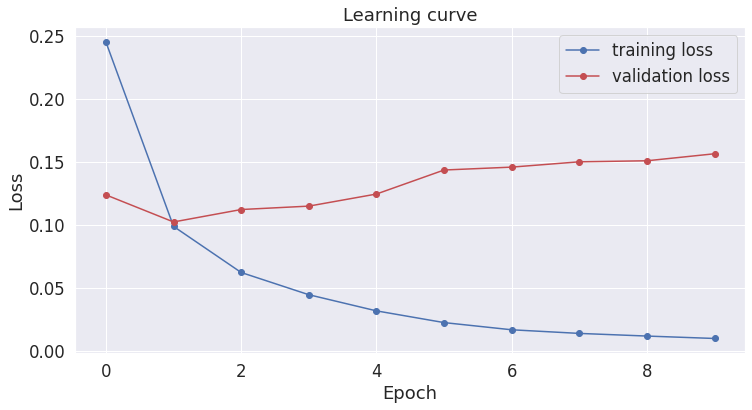

In [9]:
 # Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


#Preprocessing of evaluation data, predicting and creating tsv files

In [12]:
#TAKES A LIST [DOCID , DOCUMENT CONTENTS]

def prep_document(document):

  #PREP THE DATA
  #TOKENIZING THE ( ) , .
  text = ''
  document[1] = document[1] + ' '
  for i in range(len(document[1])-1):

    #CREATE SPACE FOR FULL STOP
    if document[1][i]=='.' and document[1][i+1] == ' ':
      text = text + ' .'
    else:
      text = text +  document[1][i]

  #CONVERT DECIMAL TO __
  tokens = text.split(' ')
  text = ''
  for token in tokens:
    if re.search('([0-9]*).([0-9]+)',token):
      token = token.replace('.' , '_')
    
    text = text + ' ' + token
    '''
  print(document[0])
  print(text)
  '''
  
  return [document[0] , text]


def predict(document):
  
  #TOKENIZING THE SENTENCE FOR BERT
  sentence = document[1]
  tokenized_sentence = tokenizer.encode(sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  error = False

  # RUNING THE BERT MODEL ON THE GIVEN INPUT
  with torch.no_grad():
    try:
      output = model(input_ids)
      label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    except:
      error = True
      return ['error'] , []


  if not error:
    #GETTING THE LABELS FOR THE TOKENS
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
    #PRINTING THE TOKENS AND CORRESPONDING LABELS
    for token, label in zip(new_tokens, new_labels):
      print("{}\t{}".format(label, token))
    
    return new_tokens , new_labels
      


def to_tsv(document):
  raw_doc = document[1]
  docID = document[0]

  doc = prep_document(document)
  tokens , labels = predict(doc)
  if tokens[0] == 'error':
    print('error')
    return

  fp = open('/content/Results/'+document[0]+'.tsv' , 'w')
  fp.write('docId\tannotSet\tannotType\tstartOffset\tendOffset\tannotId\ttext\tother\n')

  Bspan = False
  Ispan = False
  annotnum = 1
  annotID = ''
  startOffset = 0
  endOffset = 0
  text = ''
  i=0

  while i < len(tokens) - 1:

    if labels[i]== 'B-QUA' and Bspan:

       # ADD THE QUANTITY TO THE TSV FILE
      text = text.replace('_' , '.')
      startOffset = raw_doc.find(text)
      if startOffset > 0 :
        endOffset = startOffset + len(text)
        startOffset += 1
        annotID = 'T1-' + str(annotnum)
        annotnum += 1
        fp.write(docID + '\t' + str(annotnum) + '\t' + 'Quantity' + '\t' + str(startOffset) + '\t' + str(endOffset) + '\t' + annotID + '\t' + text + '\t' + str({}) + '\n')
        print(docID + '\t' + str(annotnum) + '\t' + 'Quantity' + '\t' + str(startOffset) + '\t' + str(endOffset) + '\t' + annotID + '\t' + text + '\t' + str({}) + '\n')
      text = ''
      Ispan = False
      Bspan =False

    if labels[i] == 'B-QUA':
      Bspan = True
    
    if labels[i] == 'I-QUA':
      Bspan = False
      Ispan = True
    
    if (Ispan and Bspan) or (Ispan and labels[i] == 'O') or (Bspan and labels[i] == 'O'):
      # ADD THE QUANTITY TO THE TSV FILE
      startOffset = raw_doc.find(text)
      text = text.replace('_' , '.')
      if startOffset > 0 :
        endOffset = startOffset + len(text)
        startOffset += 1 
        annotID = 'T1-' + str(annotnum)
        annotnum += 1
        fp.write(docID + '\t' + str(annotnum) + '\t' + 'Quantity' + '\t' + str(startOffset) + '\t' + str(endOffset) + '\t' + annotID + '\t' + text + '\t' + str({}) + '\n')
        print(docID + '\t' + str(annotnum) + '\t' + 'Quantity' + '\t' + str(startOffset) + '\t' + str(endOffset) + '\t' + annotID + '\t' + text + '\t' + str({}) + '\n')

      text = ''
      Ispan = False
      if Bspan and labels[i] == 'O':
        Bspan = False

    if Bspan or Ispan:

      if tokens[i+1] in ['_' , '/' , '\'']:
        text = text + tokens[i]
      elif tokens[i] in ['_' , '/' , '\'']:
        text = text + tokens[i]
      elif tokens[i] in [',' , '.' , '%' , ')' , ']']:
        text = text + tokens[i] + ' '
      elif tokens[i] in ['(' , '[']:
        text = text + tokens[i]
      else:
        text = text + ' ' + tokens[i]
      
    i = i + 1
  fp.close()

In [13]:
!mkdir Results

docID_list = glob.glob('/content/MeasEval/data/eval' + '/text/*.txt')
for docID in docID_list:
  docID = docID.replace('.txt' , '').replace('/content/MeasEval/data/eval/text/' , '')
  print(docID)
  text = open('/content/MeasEval/data/eval'+'/text/'+docID+'.txt').read()
  to_tsv([docID , text])

Streaming output truncated to the last 5000 lines.
O	attenuates
O	the
O	deformation
O	of
O	the
O	polymer
O	and
O	reduces
O	the
O	size
O	of
O	the
O	deformation
O	zone
O	ahead
O	of
O	the
O	crack
O	tip
O	,
O	but
O	this
O	effect
O	is
O	compensated
O	for
O	by
O	the
O	increased
O	energy
O	absorption
O	from
O	the
O	enhanced
O	shear
O	-
O	band
O	yielding
O	.
O	Hence
O	,
O	there
O	is
O	a
O	reduction
O	of
O	the
O	toughening
O	performance
O	of
O	the
O	S
O	-
O	CSR
O	particles
O	at
O	low
O	temperatures
O	,
O	but
O	the
O	competition
O	between
O	these
O	effects
O	results
O	in
O	the
O	fracture
O	energy
O	being
O	independent
O	of
O	the
O	test
O	temperature
B-QUA	between
I-QUA	−55
I-QUA	°C
I-QUA	and
I-QUA	−109
I-QUA	°C
O	.
O	[SEP]
S0032386113005454-2886	2	Quantity	1118	1144	T1-1	 between −55 °C and −109 °C	{}

S2213671113001306-1385
O	[CLS]
O	On
O	first
O	postoperative
O	exam
O	(
O	days
B-QUA	3
I-QUA	–
B-QUA	5
O	)
O	,
O	a
O	white
O	retinal
O	opacity
O	overlying
O	the
O	hRPE
O	implant
O	was
O	seen
O	on
O